In [175]:
!pip install textstat


# Imports

In [290]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.util import ngrams

import zlib
import math
import textstat
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, cohen_kappa_score
from scipy.special import expit

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D,GlobalAveragePooling1D,  LSTM, Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [177]:
np.random.seed(42)

# Read in Data

In [178]:
train_df = pd.read_csv("train.csv", encoding='utf-8')
val_df = pd.read_csv("dev.csv", encoding='utf-8')

## Feature extraction methods

In [179]:
def punct(document):
    """
    Creates set of counts of punctuation marks
    :param document:
    :return:
    """
    punct_counts = [document.count("!") / len(document), document.count("?") / len(document),
                    document.count(";") / len(document), document.count(":") / len(document),
                    document.count(",") / len(document), document.count(".") / len(document),
                    document.count("-") / len(document), document.count("'") / len(document)]
    return punct_counts

def punct_similarity(text1, text2):
    punct1 = punct(text1)
    punct2 = punct(text2)
    return cosine_similarity([punct1], [punct2])[0][0]

def compression_based_dissimilarity(doc1, doc2, encoding="utf-8"):
    """
    Get the CDM score (Compression-based Dissimilarity Method) for two documents:
      CDM(x, y) =  (C(x) + C(y)) / C(xy)
      (see Zhensi-Li p. 19)

    Compression algorithm is zlib's gzip.

    :param doc1: the first document (as string)
    :param doc2: the second document (as string)
    :return: the CDM score
    """
    bytes_doc1 = bytes(doc1, encoding)
    bytes_doc2 = bytes(doc2, encoding)
    return (len(zlib.compress(bytes_doc1)) / len(bytes_doc1)) + (len(zlib.compress(bytes_doc2)) / len(bytes_doc2)) / (len(zlib.compress(bytes_doc1 + bytes_doc2)) / len(bytes_doc1 + bytes_doc2))

def char_ngram_similarity(doc1, doc2, n, top=100):
    """
    Gives a positive dissimilarity score of two documents with respect to their top m character n-grams distribution.
    If the value is 0 the documents are identical (or at least share an identical top m character n-grams distribution.
    :param doc1:
    :param doc2:
    :param n: the n-gram length
    :param top: Only use the N most frequent n-grams from each document.
    :return: A positive dissimilarity score. If the value is 0 the documents are identical (or at least their top m
             character n-grams distribution.)
    """

    ngrams1 = Counter(ngrams(doc1, n))
    ngrams2 = Counter(ngrams(doc2, n))

    profile1 = [n[0] for n in ngrams1.most_common(top)]
    profile2 = [n[0] for n in ngrams2.most_common(top)]

    # normalise the two ngram distributions
    total1 = np.sum(list(ngrams1.values()))
    for key in ngrams1:
        ngrams1[key] /= total1

    total2 = np.sum(list(ngrams2.values()))
    for key in ngrams2:
        ngrams2[key] /= total2

    # calculate global dissimilarity score
    score = 0
    for n in set(profile1 + profile2):
        f1 = ngrams1[n]
        f2 = ngrams2[n]
        score += ((2 * (f1 - f2)) / (f1 + f2)) ** 2
    return expit(score)

def upper_per_lower(text1, text2):
  """
  Gives a ratio between the number of uppercase characters and lower case characters in the two texts.
  :param text1:
  :param text1:
  :return:
  """

  ratio1 = (len([i for i in text1 if i.isupper()]) + 1e-5) / (len([i for i in text1 if i.islower()]) + 1e-5)
  ratio2 = (len([i for i in text2 if i.isupper()]) + 1e-5) / (len([i for i in text2 if i.islower()]) + 1e-5)
  return comparison(ratio1, ratio2)
def entropy(tokens):
    """
    Get the Shannon entropy of a document using it's token distribution
    :param tokens: A document represented as a list of tokens.
    :return:
    """
    doc_len = len(tokens)
    frq = FreqDist(tokens)
    for key in frq.keys():
        frq[key] /= doc_len
    ent = 0.0
    for key in frq.keys():
        ent += frq[key] * math.log(frq[key], 2)
    ent = -ent
    return ent

def comparison(num1, num2):
  return (num1 - num2 + 1e-5) / (abs(num1) + abs(num2) + 1e-5)


## Main feature extraction

In [180]:
def extract_text_features(text1, text2):
  text1 = str(text1)
  text2 = str(text2)

  num_words1 = len(text1.split())
  num_words2 = len(text2.split())
  features = {
      'length': comparison(len(text1), len(text2)),
      'num_words': comparison(num_words1, num_words2),
      # 'num_sentences': comparison(len(text1.split(".")), len(text2.split("."))),
      'avg_word_length': comparison((sum(len(word) for word in text1.split()) / len(text1.split())) , (sum(len(word) for word in text2.split()) / len(text2.split()))),
      "flesch_kincaid_grade": comparison(textstat.flesch_kincaid_grade(text1), textstat.flesch_kincaid_grade(text2)),
      # "coleman_liau_index": textstat.coleman_liau_index(text1) - textstat.coleman_liau_index(text2),
      # 'automated_readability_index': comparison(textstat.automated_readability_index(text1), textstat.automated_readability_index(text2)),  # Automated Readability Index
      # 'ngram_dissimiarlarity' : char_ngram_similarity(text1, text2, 3),
      # 'compression_dissimiarlarity' : compression_based_dissimilarity(text1, text2),
      'upper_per_lower' : upper_per_lower(text1, text2),
      # 'entropy' : comparison(entropy(text1), entropy(text2)),
      'punctuation' : punct_similarity(text1, text2),
      # Add more textstat
      }

    # Lexical features using NLTK
  tokens1 = word_tokenize(text1)
  fdist1 = FreqDist(tokens1)
  tokens2 = word_tokenize(text2)
  fdist2 = FreqDist(tokens2)
  features['unique_words'] = comparison(len(fdist1), len(fdist2))  # Hapax Legomena (unique words)
  features['vocab_richness'] =  comparison((len(fdist1) / num_words1), (len(fdist2)/num_words2))  # Type-Token Ratio

  # Stylometric features
  sentence_lengths1 = [len(s) for s in text1.split(".")]
  sentence_lengths2 = [len(s) for s in text2.split(".")]
  features['sentence_length_std'] = comparison((np.std(sentence_lengths1) if sentence_lengths1 else 0), (np.std(sentence_lengths2) if sentence_lengths2 else 0))

  # Additional feature - Average character length per word
  features['avg_char_per_word'] = comparison((sum(len(word) for word in tokens1) / num_words1), (sum(len(word) for word in tokens2) / num_words2))

  return list(features.values())


## Extract Features from both training and testing data


In [181]:
train_df['text_features'] = train_df.apply(lambda row: extract_text_features(row['text_1'], row['text_2']), axis=1)
text_features = pd.DataFrame(train_df['text_features'].to_list())


In [182]:
val_df['text_features'] = val_df.apply(lambda row: extract_text_features(row['text_1'], row['text_2']), axis=1)
test_text_features = pd.DataFrame(val_df['text_features'].to_list())


In [183]:
print(text_features)

              0         1         2         3         4         5         6  \
0     -0.002554  0.034483 -0.046472  0.160001  0.071985  0.958108  0.057143   
1      0.145972  0.116883  0.036179  0.140940 -0.140826  0.863392  0.122807   
2      0.741868  0.705128  0.088888  0.163399 -0.282319  0.674200  0.596899   
3      0.922438  0.917808 -0.003583  1.000000  0.999873  0.833333  0.857143   
4     -0.010256  0.076412 -0.107085 -0.461538 -0.037222  0.394227 -0.009174   
...         ...       ...       ...       ...       ...       ...       ...   
29995  0.982090  0.970149  0.241925  1.000000 -0.810110  0.000000  0.964912   
29996  0.176638  0.205575 -0.037992 -0.184713  0.493493  0.883652  0.163265   
29997 -0.620072 -0.547170 -0.128982 -0.999992  0.415957  0.723364 -0.481481   
29998  0.057025  0.049853  0.008911 -0.046979  0.075175  0.883554  0.045455   
29999  0.301887  0.347150 -0.062307 -0.148935  0.310179  0.952029  0.313253   

              7         8         9  
0      0.0227

# Multi-layer Perceptron Model

In [184]:
optimizer = Adam(learning_rate=1e-3 )

input_dim = len(text_features.columns)  # Number of features from combined features

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=input_dim))  # Input layer
model.add(Dense(32, activation='relu', input_dim=input_dim))  # Input layer
model.add(Dense(1, activation='sigmoid'))  # Output layer (sigmoid for binary classification)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

model_checkpoint = ModelCheckpoint(filepath='best_mlp_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(text_features, train_df['label'], epochs=50,
          batch_size=8,
          validation_data=(test_text_features, val_df['label']),
          callbacks=[model_checkpoint])


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 64)                704       
                                                                 
 dense_55 (Dense)            (None, 32)                2080      
                                                                 
 dense_56 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.6829 - accuracy: 0.5568 - val_loss: 0.6813 - val_accuracy: 0.5543
Epoch 2/50
  61/3750 [..............................] - ETA: 9s - loss: 0.6572 - accuracy: 0.5922

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3750/3750 [==============================] - 8s 2ms/step - loss: 0.6778 - accuracy: 0.5685 - val_loss: 0.6778 - val_accuracy: 0.5658
Epoch 3/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.6760 - accuracy: 0.5727 - val_loss: 0.6804 - val_accuracy: 0.5630
Epoch 4/50
3750/3750 [==============================] - 8s 2ms/step - loss: 0.6751 - accuracy: 0.5726 - val_loss: 0.6768 - val_accuracy: 0.5655
Epoch 5/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.6736 - accuracy: 0.5785 - val_loss: 0.6810 - val_accuracy: 0.5580
Epoch 6/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.6731 - accuracy: 0.5791 - val_loss: 0.6771 - val_accuracy: 0.5615
Epoch 7/50
3750/3750 [==============================] - 8s 2ms/step - loss: 0.6723 - accuracy: 0.5774 - val_loss: 0.6779 - val_accuracy: 0.5560
Epoch 8/50
3750/3750 [==============================] - 8s 2ms/step - loss: 0.6714 - accuracy: 0.5835 - val_loss: 0.6769 - val_accuracy: 0.5685
Epo

# Model Evaluation

In [291]:
model = load_model('5831_mlp_model.keras')

predictions = model.predict(test_text_features)
binary_predictions = (predictions > 0.5).astype(int)

y_true = val_df['label']
y_pred = binary_predictions

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

report = classification_report(y_true, y_pred, output_dict=True)

precision_class_0 = report['0']['precision']
recall_class_0 = report['0']['recall']
precision_class_1 = report['1']['precision']
recall_class_1 = report['1']['recall']

print("\nPrecision (Class 0):", precision_class_0)
print("Recall (Class 0):", recall_class_0)
print("Precision (Class 1):", precision_class_1)
print("Recall (Class 1):", recall_class_1)

f1 = f1_score(y_true, y_pred)
print("\nF1-score:", f1)

tn, fp, fn, tp = conf_matrix.ravel()
numerator = tp * tn - fp * fn
denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
mcc = numerator / (denominator + np.spacing(1))
print("\nMCC:", mcc)

kappa = cohen_kappa_score(y_true, y_pred)
print("\nCohen's Kappa:", kappa)

188/188 [==============================] - 1s 3ms/step
Accuracy: 0.5831666666666667
Confusion Matrix:
 [[1881 1108]
 [1393 1618]]

Precision (Class 0): 0.5745265729993891
Recall (Class 0): 0.6293074606891937
Precision (Class 1): 0.5935436537050623
Recall (Class 1): 0.537363002324809

F1-score: 0.5640578699668818

MCC: 0.16736888152729984

Cohen's Kappa: 0.16661242557214728


In [186]:
model.save(f'best_model_A.keras')


# Experimentation

In [284]:
def extract_text_features(text1, text2):
  text1 = str(text1)
  text2 = str(text2)

  num_words1 = len(text1.split())
  num_words2 = len(text2.split())
  features = {
      'length': comparison(len(text1), len(text2)),
      'num_words': comparison(num_words1, num_words2),
      # 'num_sentences': comparison(len(text1.split(".")), len(text2.split("."))),
      'avg_word_length': comparison((sum(len(word) for word in text1.split()) / len(text1.split())) , (sum(len(word) for word in text2.split()) / len(text2.split()))),
      "flesch_kincaid_grade": comparison(textstat.flesch_kincaid_grade(text1), textstat.flesch_kincaid_grade(text2)),
      # "coleman_liau_index": textstat.coleman_liau_index(text1) - textstat.coleman_liau_index(text2),
      # 'automated_readability_index': comparison(textstat.automated_readability_index(text1), textstat.automated_readability_index(text2)),  # Automated Readability Index
      # 'ngram_dissimiarlarity' : char_ngram_similarity(text1, text2, 3),
      # 'compression_dissimiarlarity' : compression_based_dissimilarity(text1, text2),
      'upper_per_lower' : upper_per_lower(text1, text2),
      # 'entropy' : comparison(entropy(text1), entropy(text2)),
      'punctuation' : punct_similarity(text1, text2),
      # Add more textstat
      }

    # Lexical features using NLTK
  tokens1 = word_tokenize(text1)
  fdist1 = FreqDist(tokens1)
  tokens2 = word_tokenize(text2)
  fdist2 = FreqDist(tokens2)
  features['unique_words'] = comparison(len(fdist1), len(fdist2))  # Hapax Legomena (unique words)
  features['vocab_richness'] =  comparison((len(fdist1) / num_words1), (len(fdist2)/num_words2))  # Type-Token Ratio

  # Stylometric features
  sentence_lengths1 = [len(s) for s in text1.split(".")]
  sentence_lengths2 = [len(s) for s in text2.split(".")]
  features['sentence_length_std'] = comparison((np.std(sentence_lengths1) if sentence_lengths1 else 0), (np.std(sentence_lengths2) if sentence_lengths2 else 0))

  # Additional feature - Average character length per word
  features['avg_char_per_word'] = comparison((sum(len(word) for word in tokens1) / num_words1), (sum(len(word) for word in tokens2) / num_words2))

  return list(features.values())


In [285]:
train_df['text_features'] = train_df.apply(lambda row: extract_text_features(row['text_1'], row['text_2']), axis=1)
text_features = pd.DataFrame(train_df['text_features'].to_list())
val_df['text_features'] = val_df.apply(lambda row: extract_text_features(row['text_1'], row['text_2']), axis=1)
test_text_features = pd.DataFrame(val_df['text_features'].to_list())


In [263]:
optimizer = Adam(learning_rate=1e-3 )

input_dim = len(text_features.columns)  # Number of features from combined features

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=input_dim))  # Input layer
model.add(Dense(32, activation='relu', input_dim=input_dim))  # Input layer
model.add(Dense(1, activation='sigmoid'))  # Output layer (sigmoid for binary classification)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

model_checkpoint = ModelCheckpoint(filepath='best_mlp_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(text_features, train_df['label'], epochs=10,
          batch_size=16,
          validation_data=(test_text_features, val_df['label']),
          callbacks=[model_checkpoint])



Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 64)                640       
                                                                 
 dense_103 (Dense)           (None, 32)                2080      
                                                                 
 dense_104 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2753 (10.75 KB)
Trainable params: 2753 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6849 - accuracy: 0.5526 - val_loss: 0.6815 - val_accuracy: 0.5488
Epoch 2/10
  84/1875 [>.............................] - ETA: 3s - loss: 0.6813 - accuracy: 0.5610

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - 4s 2ms/step - loss: 0.6792 - accuracy: 0.5646 - val_loss: 0.6808 - val_accuracy: 0.5507
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6773 - accuracy: 0.5703 - val_loss: 0.6781 - val_accuracy: 0.5608
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6750 - accuracy: 0.5734 - val_loss: 0.6779 - val_accuracy: 0.5643
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6740 - accuracy: 0.5743 - val_loss: 0.6747 - val_accuracy: 0.5658
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6733 - accuracy: 0.5762 - val_loss: 0.6742 - val_accuracy: 0.5708
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6725 - accuracy: 0.5794 - val_loss: 0.6754 - val_accuracy: 0.5710
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6716 - accuracy: 0.5804 - val_loss: 0.6757 - val_accuracy: 0.5708
Epo

In [264]:

predictions = model.predict(test_text_features)
binary_predictions = (predictions > 0.5).astype(int)

# Evaluate model performance (accuracy)
accuracy = accuracy_score(val_df['label'], binary_predictions)
print(accuracy)

188/188 [==============================] - 0s 1ms/step
0.5741666666666667


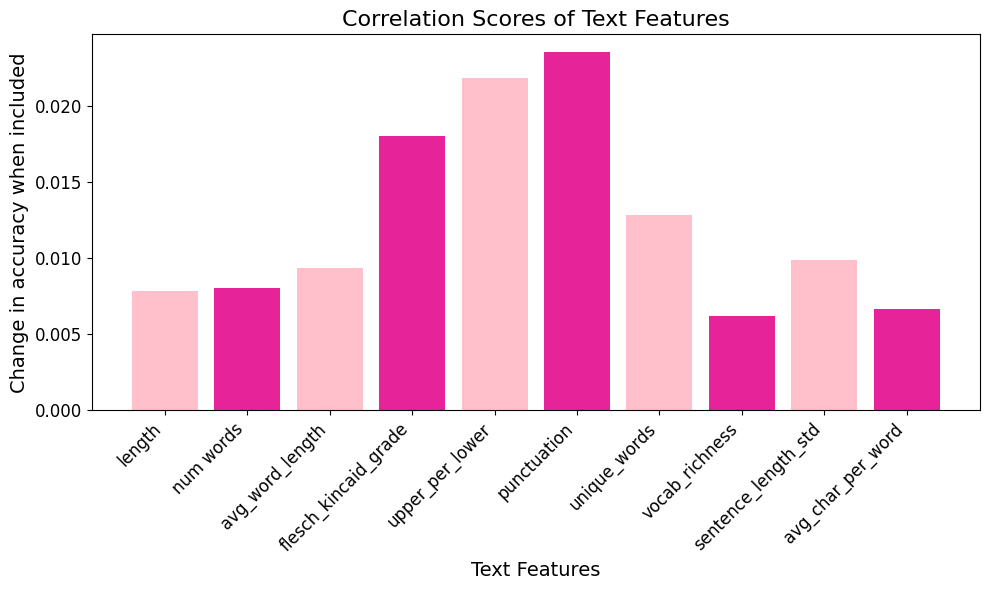

In [280]:
# Results collected from multiple runnings of above cells
result_dic = {'length': 0.573,
              'num words' : 0.5728333333333333,
              'avg_word_length' : 0.5715,
              'flesch_kincaid_grade' : 0.5628333333333333,
              'upper_per_lower' : 0.559,
              'punctuation' : 0.5573333333333333,
              'unique_words' : 0.568,
              'vocab_richness' : 0.5746666666666667,
              'sentence_length_std' : 0.571,
              'avg_char_per_word' : 0.5741666666666667,
}
all = 0.5808333333333333
for key in result_dic.keys():
  result_dic[key] = all - result_dic[key]



pink1 = '#FFC0CB'
pink2 = '#E62398'

result_labels = list(result_dic.keys())
result_values = list(result_dic.values())

plt.figure(figsize=(10, 6))  # Adjust figure size as desired
bar_colors = [pink1 if i % 2 == 0 else pink2 for i in range(len(result_labels))]  # Alternate colors
plt.bar(result_labels, result_values, color=bar_colors)

plt.xlabel("Text Features", fontsize=14)
plt.ylabel("Change in accuracy when included", fontsize=14)
plt.title("Correlation Scores of Text Features", fontsize=16)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()



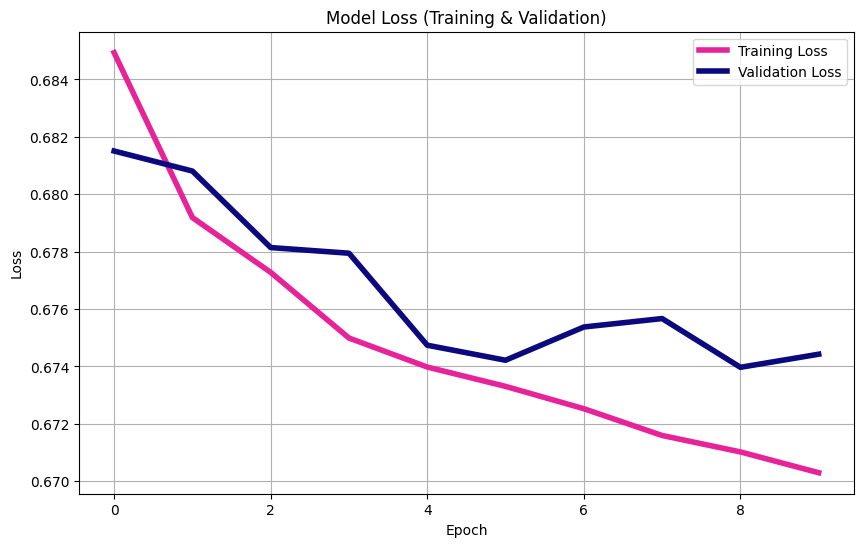

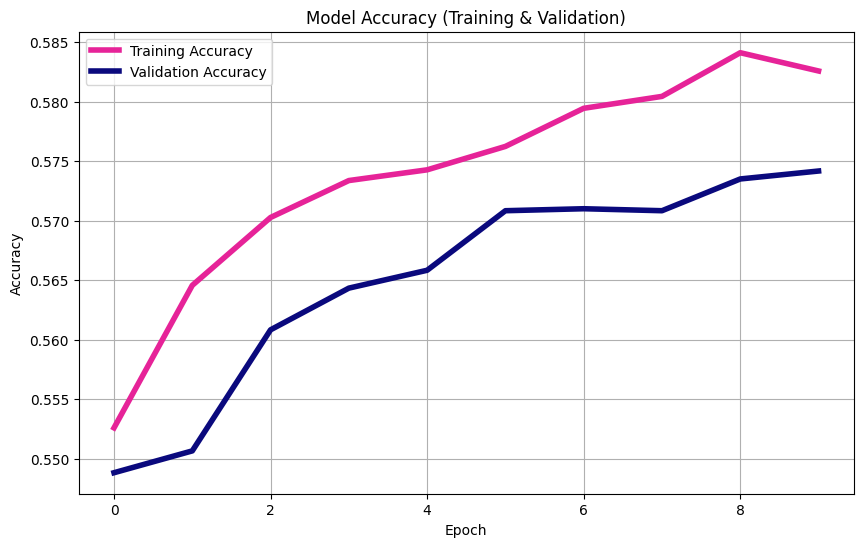

In [286]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='#E62398', linewidth=4)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#0A097D', linewidth=4)
plt.title('Model Loss (Training & Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#E62398', linewidth=4)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#0A097D', linewidth=4)
plt.title('Model Accuracy (Training & Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()